This is practice for ML on MNIST digits taken from https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical #convert to one-hot encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

In [14]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

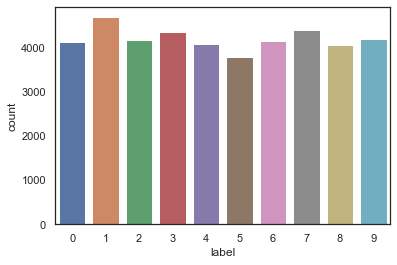

In [17]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"], axis = 1) 
# Free some space
del train

g = sns.countplot(Y_train)

Y_train.value_counts()

In [18]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [19]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

This checked for corrupt images (missing values inside). Looks like there are no missing values in the train and test datasets.

We perform grayscale normalization to reduce the effect of illumination's differences.

Also, the CNN converges faster on [0,1] data than on [0, 255].

In [20]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [21]:
# Reshape the image in 3 dimensions (height = 28px, width = 28px, depth = 1)

X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

The train and test images we received were pandas.Dataframe as 1D vectors of length 784.  We reshape all of it into 28x28x1 matrices.

If we were using colors, as in RGC, we would use 28x28x3 matrices.

These are known as channels.

In [22]:
# Encode labels to one hot vectors (ex: 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digit numbers from 0 to 9. We need to encode these labels as one hot vectors (ex: 2 -> [0,0,1,0,0,0,0,0,0,0]).

In [23]:
# Set the random seed
random_seed = 2

In [25]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, 
                                                  random_state = random_seed)

We split the train set into 10% validation and 90% to train the model.

Since we have 42,000 training images of balanced labels, a random split of the train set doesn't cause some of the labels to be over represented in the validation set.  This can be an issue if the dataset is unbalanced, since a simple random split could cause inaccurate evaluation during the validation.

To avoid this in that case, use stratify = True option in train_test_split function (only for >= 0.17 sklearn versions)

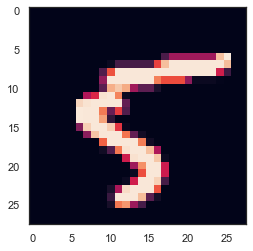

In [28]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

CNN (Convolutional Neural Network)

Defining the model.

This user used Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first convolutional layer : Conv2D;
Description: A set of learnable filters.
Rationale: Chose to set 32 filters for the first two Conv2D layers and 64 filters for the last two. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.




The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

MaxPool2D: Acts as a "downsampling" filter. It looks at the the 2 neighbroing pixes and picks the maximal value. These are used to reduce computational cost and to some extent also reduce overfiting.  We have to choose the pooling size ((i.e. the area size polled each time). The higher the pooling dimesion, the more downsampling is important.

Downsampling is a process applied to digital signals which reduces the amplitude of certain features, is my best guess.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their weights to zero) for each training sample. This drops randomly a proportion of the network and forces the network to learn features in a distributed way.  This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x).) The rectifier acitivation function is used to add non-linearity to the network.

The Flatten layer is used to convert the final feature maps into a single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

This user used the features in two fully-connected (Dense) layers which is just Artifical an Neural Networks (ANN) classifier.  In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [34]:
# Set the CNN model
# my CNN architecture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten 
# -> Dense -> Dropout -> Out]

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                            activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                               activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                               activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                              activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

Now we set up a score function, a loss function, and an optimisation algorithm.

Define the loss function to measure how poorly our model performs with known labels.  It is the error rate between the observed labels and the predicted ones.  This user uses a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameter (filters kernel values, weights and bias of neurons...) in order to minimize the loss.

This user chose RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSProp.

The metric function ""accuracy" is used to evaluate the performance of our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation.)

In [35]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay =0.0)

In [37]:
# Complie the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, he used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher the LR, the bigger the steps and the quicker is the convergence. However, the sampling is very poor with a high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the traiing to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, he decreased the LR dynamically every X steps (epochs) depending on if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, I choose to reduce the LR by half if the accuracy is not imporvoed after 3 epochs.

In [53]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)

In [64]:
epochs = 30 # Turn to 30 to get 0.9967 accuracy
batch_size = 86

In ordre to avoid overfitting, we need to expand artificially the handwritten digit data set. We can make the existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered, the scale is not the same (some write with big/small numbers), the image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and many more.

By applying just a couple of these transformations to out training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important:
˚Without data augmentation accuracy is 98.114%
˚With, 99.67%

In [55]:
# Without data augmentation he obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
#                    validation_data = (X_val, Y_val), verbose = 2)

In [65]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False, #set input mean to 0 over the dataset
        samplewise_center=False,  #set each sample mean to 0
        featurewise_std_normalization=False,  #divide inputs by std of the dataset
        samplewise_std_normalization=False,    #divide each input by its std
        zca_whitening=False,       #apply ZCA whitening
        rotation_range=10,        # randomly rotate images in the range (degrees, 0 to 100)
        zoom_range = 0.1,          # randomly zoom
        width_shift_range=0.1,     # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,    # randomly shift images vertically (fraction of total width)
        horizontal_flip=False,    # randomly flip images
        vertical_flip=False)      # randomly flip images

datagen.fit(X_train)

For the data augmentation:
 Randomly rotate by 10˚, zoom by 10%, shift hor/vert by 10%.
 
 NO vertical flip or horiz flip since numbers can be symmetrric, and this would cause 69 issues.

In [66]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),
                             epochs = epochs, validation_data = (X_val, Y_val),
                             verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,
                             callbacks = [learning_rate_reduction])

Epoch 1/30
 - 88s - loss: 0.0696 - accuracy: 0.9786 - val_loss: 0.0477 - val_accuracy: 0.9897
Epoch 2/30
 - 87s - loss: 0.0644 - accuracy: 0.9811 - val_loss: 0.0371 - val_accuracy: 0.9899
Epoch 3/30
 - 86s - loss: 0.0589 - accuracy: 0.9822 - val_loss: 0.0363 - val_accuracy: 0.9913
Epoch 4/30
 - 86s - loss: 0.0612 - accuracy: 0.9825 - val_loss: 0.0382 - val_accuracy: 0.9910
Epoch 5/30
 - 86s - loss: 0.0591 - accuracy: 0.9826 - val_loss: 0.0398 - val_accuracy: 0.9915
Epoch 6/30
 - 96s - loss: 0.0581 - accuracy: 0.9827 - val_loss: 0.0419 - val_accuracy: 0.9907
Epoch 7/30
 - 93s - loss: 0.0535 - accuracy: 0.9850 - val_loss: 0.0408 - val_accuracy: 0.9902
Epoch 8/30
 - 91s - loss: 0.0563 - accuracy: 0.9847 - val_loss: 0.0491 - val_accuracy: 0.9905

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/30
 - 93s - loss: 0.0426 - accuracy: 0.9876 - val_loss: 0.0377 - val_accuracy: 0.9921
Epoch 10/30
 - 96s - loss: 0.0439 - accuracy: 0.9872 - val_loss: 0.0413 -

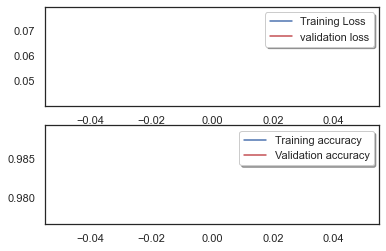

In [62]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='validation loss', axes =ax[0])
legen = ax[0].legend(loc='best', shadow = True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
legen = ax[1].legend(loc='best', shadow=True)

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [67]:
# predict results
results = model.predict(test)

#select the index with the maximum probability
results = np.argmax(results, axis=1)

results = pd.Series(results, name='Label')

In [70]:
submission = pd.concat([pd.Series(range(1,28001),name="ImageId"),results],axis=1)

submission.to_csv("cnn_mnist_datgen.csv",index=False)